In [281]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from statistics import NormalDist
import math
import random

In [2]:
files = os.listdir('./db/agregs_pesqs/')

In [7]:
df = pd.DataFrame()
for file in files:
    with open(f'./db/agregs_pesqs/{file}', 'r', encoding='latin1') as f:
        arqv = json.load(f)
    n_df = pd.DataFrame(arqv)
    df = pd.concat([df, n_df])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Open arqv

In [8]:
df = pd.read_excel('./db/agregs_pesqs/pesqss_agreg.xlsx')

In [185]:
teste = df[['candidato', 'candidatos_id']].groupby('candidato').mean()
teste.to_excel('idds.xlsx')

In [16]:
presenciais = ['Datafolha', 'Ipec', 'Ibope', 'Quaest', 'Paraná Pesquisas', 'Vox Populi', 'Sensus']

In [110]:
df_lula_2022 = df[(df['candidato']=='Lula') & (df['instituto'].isin(presenciais)) & (df['ano']==2022) ].reset_index()

In [133]:
def calc_chance_1_turno(margem, n, p_hat):
    z = margem / math.sqrt((p_hat * (1 - p_hat) / n))
    return 1 - NormalDist(p_hat, margem / z).cdf(.50)


In [222]:
def is_branco_nulo(name):
    lista = ['não', 'branco', 'nulo', 'indeciso', 'não votará', 'nenhum', 'não iria votar', 'não respondeu', 'não sabe', 'Não votaria em nenhum']
    name_split = name.lower().split('/')
    for teste in name_split:
        if teste in lista:
            return True
    return False

def find_branco_nulo(cenario_id, instituto, data):
    data_filtered = data[(data['cenario_id'] == cenario_id) & (data['instituto'] == instituto)].reset_index()
    data_filtered.loc[:, 'is_inv'] = data_filtered.loc[:, 'candidato'].apply(is_branco_nulo)
    invs = data_filtered[data_filtered['is_inv']]['percentual']
    invs_float = [float(number) for number in invs]
    return sum(invs_float) / 100



In [284]:
chances = []
for i, p_hat in enumerate(df_lula_2022['percentual']):
    cenario_id = df_lula_2022.loc[i, 'cenario_id']
    instituto = df_lula_2022.loc[i, 'instituto']
    v_invs = find_branco_nulo(cenario_id, instituto, df)
    margem = float(df_lula_2022.loc[i, 'margem_mais'])
    n = df_lula_2022.loc[i, 'qtd_entrevistas']
    if margem == 0 or n == 0 or p_hat == 0 or str(n) == 'nan':
        continue
    p_hat_validos = (p_hat /100 )/ (1 - v_invs) + random.randint(0, 10) / 1000
    chances.append(calc_chance_1_turno(margem / 100, int(n), p_hat_validos))

In [285]:
df_lula_2022['chance_1_turno'] = chances
df_lula_2022.to_excel('df_lula_2022.xlsx')

<AxesSubplot:xlabel='data_pesquisa'>

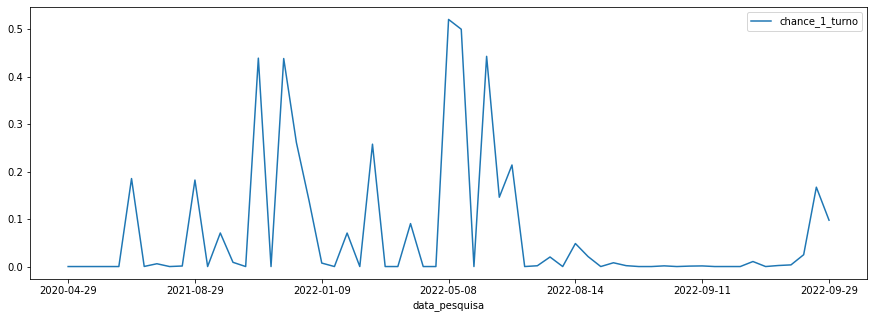

In [286]:
df_agreg = df_lula_2022.groupby('data_pesquisa')[['chance_1_turno']].mean()
df_agreg.plot(figsize=[15,5])

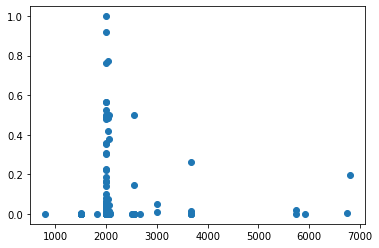

In [287]:
plt.scatter('qtd_entrevistas', 'chance_1_turno', data = df_lula_2022)

<AxesSubplot:xlabel='instituto'>

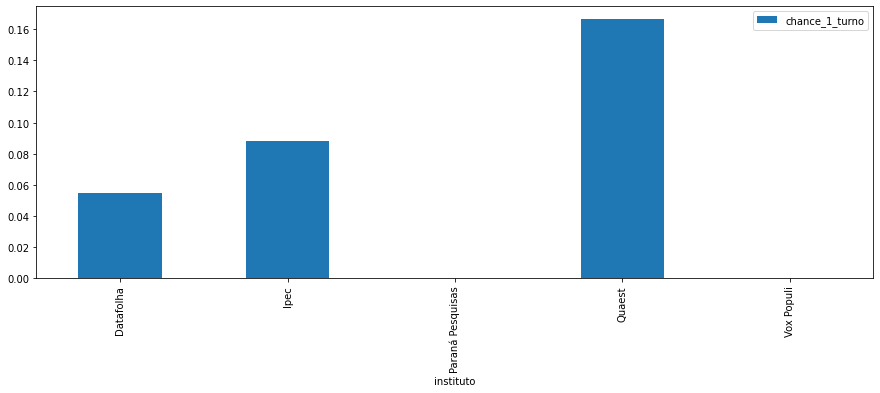

In [288]:
df_agreg = df_lula_2022.groupby('instituto')[['chance_1_turno']].mean()
df_agreg.plot(figsize=[15,5], kind='bar')

ponderar chances

In [289]:
from datetime import datetime
import numpy as np

In [290]:
def weights_from_date(date):
    days_from_today = (datetime.today() - datetime.strptime(date, "%Y-%m-%d")).days
    return 1 / days_from_today

In [291]:
df_lula_2022['w_days'] = df_lula_2022['data_pesquisa'].apply(weights_from_date)

In [292]:
wm = lambda x: np.average(x, weights=df_lula_2022.loc[x.index, "w_days"])

In [293]:
df_final = df_lula_2022.groupby('data_pesquisa').agg(chance_w_mean=("chance_1_turno", wm))

In [294]:
sum(df_lula_2022['chance_1_turno'] * df_lula_2022['w_days']) / sum(df_lula_2022['w_days'])

0.07078230852992663

SIMULAÇÕES

In [317]:
from tqdm import tqdm
from drawnow import drawnow

In [325]:
sims = []
for i in tqdm(range(10000)):
    chances = []
    for i, p_hat in enumerate(df_lula_2022['percentual']):
        cenario_id = df_lula_2022.loc[i, 'cenario_id']
        instituto = df_lula_2022.loc[i, 'instituto']
        v_invs = find_branco_nulo(cenario_id, instituto, df)
        margem = float(df_lula_2022.loc[i, 'margem_mais'])
        n = df_lula_2022.loc[i, 'qtd_entrevistas']
        if margem == 0 or n == 0 or p_hat == 0 or str(n) == 'nan':
            continue
        p_hat_validos = (p_hat /100 )/ (1 - v_invs) + random.randint(0, 10) / 1000
        chances.append(calc_chance_1_turno(margem / 100, int(n), p_hat_validos))
    df_lula_2022['chance_1_turno'] = chances
    df_lula_2022['w_days'] = df_lula_2022['data_pesquisa'].apply(weights_from_date)
    chance_pond = sum(df_lula_2022['chance_1_turno'] * df_lula_2022['w_days']) / sum(df_lula_2022['w_days'])
    sims.append(chance_pond)

  0%|          | 7/10000 [00:03<1:44:52,  1.59it/s]

TypeError: object of type 'generator' has no len()

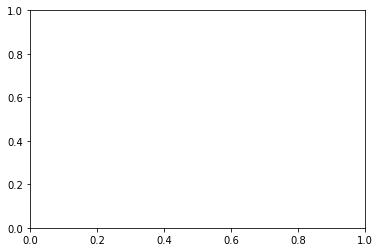

In [311]:
plt.hist(sim_generateor())